In [1]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

print("role:"+role)

region = boto3.Session().region_name

print("region:"+region)

bucket='ml-trainings' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket
print("bucketpath:"+bucket_path)

role:arn:aws:iam::735965530228:role/service-role/AmazonSageMaker-ExecutionRole-20190612T102087
region:us-east-1
bucketpath:https://s3-us-east-1.amazonaws.com/ml-trainings


In [2]:
%%time 
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 949 ms, sys: 287 ms, total: 1.24 s
Wall time: 2.27 s


This is a 5


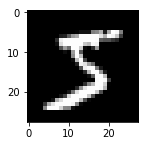

This is a 0


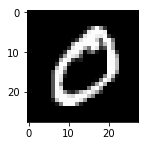

This is a 4


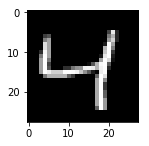

This is a 1


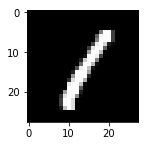

This is a 9


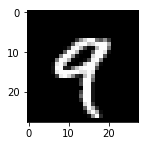

This is a 2


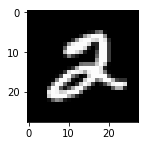

This is a 1


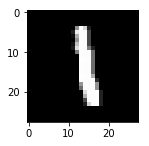

This is a 3


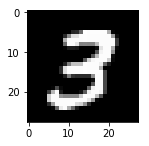

This is a 1


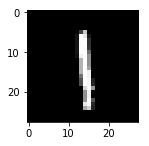

This is a 4


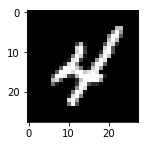

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()



In [4]:
%%time

import struct
import io
import csv
import boto3
        
def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3n://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3n://ml-trainings/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3n://ml-trainings/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3n://ml-trainings/sagemaker/xgboost-mnist/test/examples
CPU times: user 36.6 s, sys: 4.98 s, total: 41.6 s
Wall time: 55.7 s


In [5]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [ ]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}
xgb_model.fit(inputs=data_channels,  logs=True)

s3://ml-trainings/sagemaker/xgboost-mnist/train
2019-06-19 09:52:52 Starting - Starting the training job...
2019-06-19 09:52:54 Starting - Launching requested ML instances......
2019-06-19 09:53:56 Starting - Preparing the instances for training...
2019-06-19 09:54:46 Downloading - Downloading input data......
2019-06-19 09:55:41 Training - Training image download completed. Training in progress.
Arguments: train
[2019-06-19:09:55:42:INFO] Running standalone xgboost training.
[2019-06-19:09:55:42:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8387.13mb
[2019-06-19:09:55:42:INFO] Determined delimiter of CSV input is ','
[09:55:42] S3DistributionType set as FullyReplicated
[09:55:49] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-06-19:09:55:49:INFO] Determined delimiter of CSV input is ','
[09:55:49] S3DistributionType set as FullyReplicated
[09:55:50] 10000x784 matr

In [7]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.c4.xlarge',
                                )

----------------------------------------------------------------------------------------------------!

In [8]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 7


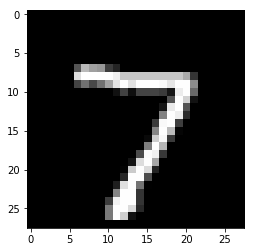

This is a 2


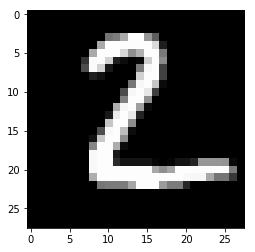

This is a 1


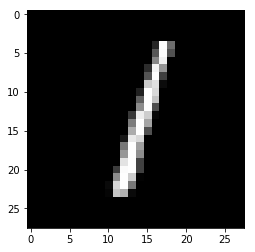

This is a 0


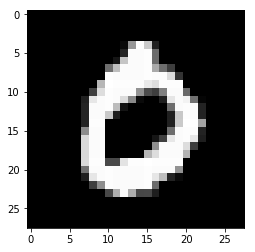

This is a 4


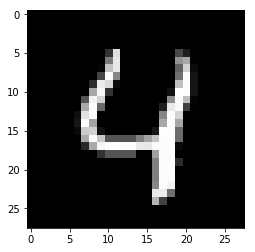

This is a 1


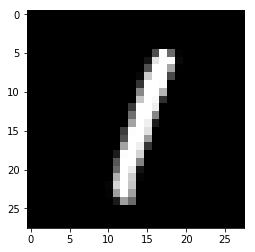

This is a 4


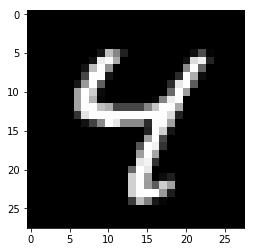

This is a 9


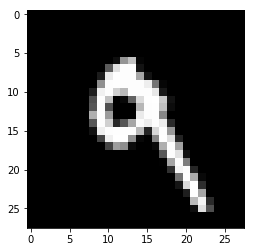

This is a 5


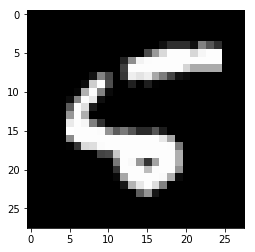

This is a 9


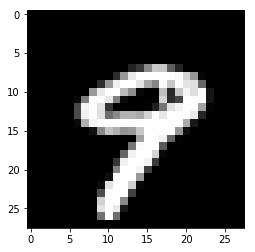

In [9]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [10]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)

b'7.0'
b'2.0'
b'1.0'
b'0.0'
b'4.0'
b'1.0'
b'4.0'
b'9.0'
b'5.0'
b'9.0'
